### V1DD Figure 1

In [1]:
from v1dd_public import ARTIFACT_DIR
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms
import numpy as np
from pathlib import Path
from allen_v1dd.client import OPhysClient

In [2]:
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
# color = ['red', 'blue', 'orange', 'green']
# color = ['#88CCEE', "#44AA99", "#117733", "#999933"] 
# color = ['#88CCEE', "#117733", "#DDCC77", "#CC6677"]
# color = ['#0077BB', "#009988", "#EE7733", "#EE3377"]
color = ["#66CCEE", "#228833", "#CCBB44", "#EE6677"]
all_z = [50, 66, 82, 98, 114, 130, 146, 162, 178, 194, 210, 226, 242, 258, 274, 290, 306, 322, 338, 354, 370, \
    386, 402, 418, 434, 450, 466, 482, 498, 514, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725]

#### Load and preprocess the data

In [3]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [4]:
print(f"There are {len(cell_info)} total neurons.")

There are 88351 total neurons.


#### Plot the number of ROIs vs depth

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


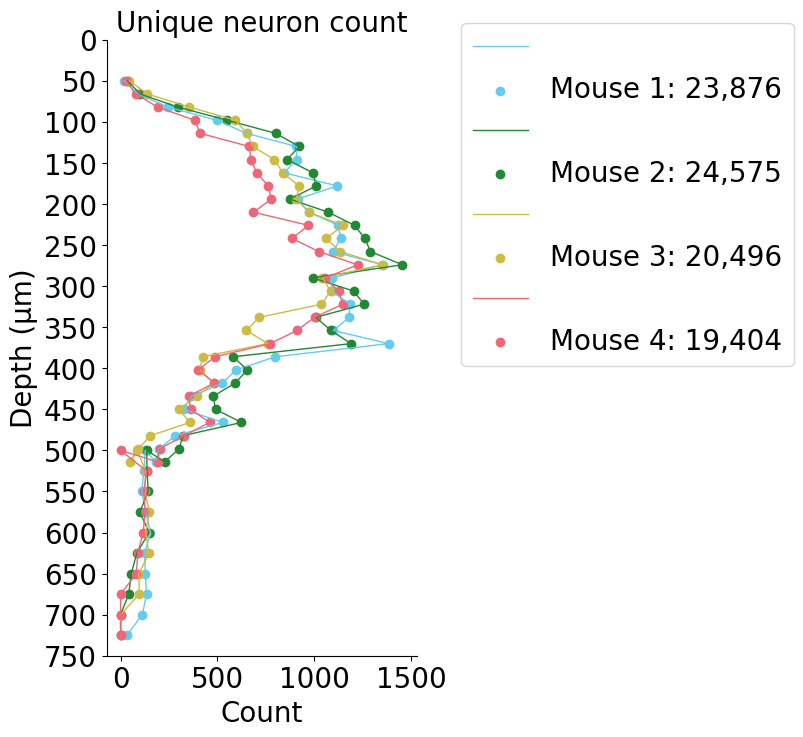

In [27]:
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot(111)
data = np.zeros([len(all_z), 4])
for i, z in enumerate(all_z):
    for k in range(len(mice)):
        plane = (cell_info['z']==z) & (cell_info['mouse_id']==mice[k])
        data[i, k] = cell_info[plane].shape[0]
        
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(90)

for i in range(4):
    
    ax.plot(data[:, i], all_z,
            linewidth=1, color = color[i])
    plt.scatter(all_z, 
                -data[:, i], 
                color = color[i], 
                label = mice[i],
                transform = rot + base)

plt.legend(["", "Mouse 1: 23,876", "", "Mouse 2: 24,575", "", "Mouse 3: 20,496","",  "Mouse 4: 19,404"], bbox_to_anchor=(1.1, 1.05), fontsize=20)
plt.ylim(0, 750)
plt.yticks(np.arange(0, 800, 50), fontsize=20)
plt.xticks(np.arange(0, 1501, 500), fontsize=20)
plt.gca().invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Unique neuron count', fontsize=20)
plt.xlabel('Count', fontsize=20)
plt.ylabel('Depth (µm)', fontsize=20)

plt.savefig('/home/naomi/Desktop/figures/v1dd_plots/1E_population_depth_boxplot.eps', dpi=300, bbox_inches='tight')

### Plot example session order

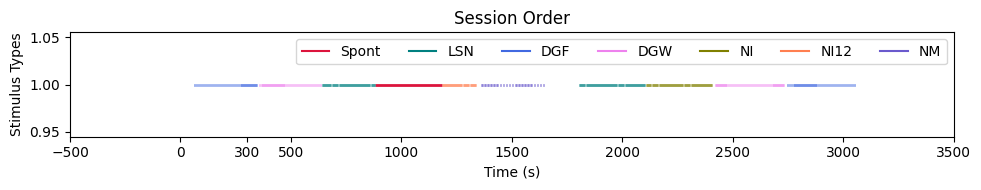

In [ ]:
mouse_id = 'M427836'
col_vol_str = '51'
plane = 2
plane_name = f"Plane_{plane}"

# DATA_DIR = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/")
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session('M427836_11')
stim_names = ["spontaneous", "locally_sparse_noise", "drifting_gratings_full", \
              "drifting_gratings_windowed", "natural_images", "natural_images_12", "natural_movie"]
stim_labels = ["Spont", "LSN", "DGF", \
              "DGW", "NI", "NI12", "NM"]
plt.figure(figsize=(10, 2))
colors = ['crimson', 'teal', 'royalblue', 'violet', 'olive', 'coral', 'slateblue']
y_position = 1
for index, (stim_name, color) in enumerate(zip(stim_names, colors)):
    stim_table_tuple = session.get_stimulus_table(stim_name)
    stim_table = stim_table_tuple[0]

    for _, row in stim_table.iterrows():
        plt.hlines(y=y_position, xmin=row['start'], xmax=row['end'], color=color, linewidth=2)

for stim_name, color in zip(stim_labels, colors):
    plt.plot([], [], color=color, label=stim_name)

current_xticks = plt.xticks()[0]
new_xticks = sorted(list(current_xticks) + [300])
plt.xticks(new_xticks)
plt.xlabel('Time (s)')
plt.ylabel('Stimulus Types')
plt.title('Session Order')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=7)
plt.tight_layout()
plt.show()

# plt.savefig('session_order.eps', format='eps')